<a href="https://colab.research.google.com/github/GiovaniValdrighi/inferencia_causal/blob/master/vae/scm_counterfactual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
!pip3 install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl
!pip3 install torchvision
!pip3 install pyro-ppl

ERROR: torch-0.4.0-{platform}-linux_x86_64.whl is not a valid wheel filename.
     |████████████████████████████████| 491kB 2.8MB/s 
     |████████████████████████████████| 61kB 8.2MB/s 
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1


In [0]:
import numpy as np
import torch
from vae_build import VAE, ind_from_att, label_from_dummy
import pyro
import matplotlib.pyplot as plt
from pyro.distributions import OneHotCategorical, RelaxedOneHotCategorical, Normal, Uniform, constraints

In [6]:
dataset_zip = np.load('/content/gdrive/My Drive/autoencoder/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz', allow_pickle = True, encoding = 'bytes')
print('Keys in the dataset:', dataset_zip.files)
imgs = dataset_zip['imgs']
latents_values = dataset_zip['latents_values']
latents_classes = dataset_zip['latents_classes']
latents_sizes = dataset_zip['metadata'][()][b'latents_sizes']
latents_names = dataset_zip['metadata'][()][b'latents_names']

Keys in the dataset: ['metadata', 'imgs', 'latents_classes', 'latents_values']


In [7]:
#pyro.enable_validation(True)
pyro.clear_param_store()
#the training routine
use_CUDA = False
vae = VAE(latents_sizes, latents_names, use_CUDA = use_CUDA)
vae.load_state_dict(torch.load('/content/gdrive/My Drive/trained_movel_epoch_24.save'))

<All keys matched successfully>

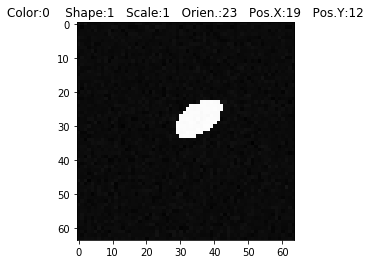

In [176]:
class SCM():
  def __init__(self, vae):
    self.vae = vae
    self.latents_names = ['color', 'shape', 'scale', 'orien', 'posX', 'posY']
    self.latents_sizes = {'color' : 1, 'shape': 3, 'scale':6, 'orien': 40, 'posX': 32, 'posY':32}
    self.init_noise = {'color': OneHotCategorical(probs = torch.tensor([1.])),
                       'shape': OneHotCategorical(probs = torch.tensor([1/3]).repeat(3)),
                       'scale': OneHotCategorical(probs =torch.tensor([1/6]).repeat(6)),
                       'orien': OneHotCategorical(probs =torch.tensor([1/40]).repeat(40)),
                       'posX': OneHotCategorical(probs =torch.tensor([1/32]).repeat(32)),
                       'posY': OneHotCategorical(probs =torch.tensor([1/32]).repeat(32)),
                       'latent': Normal(torch.zeros(200), torch.ones(200)),
                       'img': Uniform(torch.zeros(4096), torch.ones(4096))}
    
    #functions for the model
    def f_gumbel(N):
      return N
    
    def f_posX(N, scale):
      if 31 <= int(scale.max(0)[1] + N.max(0)[1]):
        return torch.nn.functional.one_hot(torch.tensor([31]), 32).to(torch.float32).reshape([32])
      else:
        return torch.nn.functional.one_hot(scale.max(0)[1] + N.max(0)[1], 32).to(torch.float32).reshape([32])

    def f_latent(N_latent, ind, label):
      mu, sigma = vae.encoder.forward(torch.tensor(imgs[ind]).reshape(4096).to(torch.float32), label)
      return N_latent * sigma + mu

    def f_image(N_img, latent, label):
      img_decode = vae.decoder.forward(latent, label)
      return (N_img > img_decode).to(torch.float)

 
    def model(noise = self.init_noise):

      #Noise variables
      N_color = pyro.sample('N_color', noise['color'])
      N_shape = pyro.sample('N_shape', noise['shape'])
      N_scale = pyro.sample('N_scale', noise['scale'])
      N_orien = pyro.sample('N_orien', noise['orien'])
      N_posX = pyro.sample('N_posX', noise['posX'])
      N_posY = pyro.sample('N_posY', noise['posY'])
      N_latent = pyro.sample('N_latent', noise['latent'])
      N_img = pyro.sample('N_img', noise['img'])

      #variables
      color = pyro.sample('color', Normal(f_gumbel(N_color), torch.tensor([0.01])).to_event(1))
      shape = pyro.sample('shape', Normal(f_gumbel(N_shape), torch.tensor([0.01])).to_event(1))
      scale = pyro.sample('scale', Normal(f_gumbel(N_scale), torch.tensor([0.01])).to_event(1))
      orien = pyro.sample('orien', Normal(f_gumbel(N_orien), torch.tensor([0.01])).to_event(1))
      posX = pyro.sample('posX', Normal(f_posX(N_posX, scale), torch.tensor([0.01])).to_event(1))
      posY = pyro.sample('posY', Normal(f_gumbel(N_posY), torch.tensor([0.01])).to_event(1))

      #fixing values to the decoder
      ind = ind_from_att(color.max(0)[1], shape.max(0)[1], scale.max(0)[1], orien.max(0)[1], posX.max(0)[1], posY.max(0)[1])
      label = torch.round(torch.cat([color, shape, scale, orien, posX, posY], -1))
      
      #variables
      latent = pyro.sample('latent', Normal(f_latent(N_latent, ind, label), torch.tensor([0.01])).to_event(1))
      img = pyro.sample('img', Normal(f_image(N_img, latent, label), torch.tensor([0.01])).to_event(1))

      return label, latent, img
    
    def guide(noise):
      #setting noises categorical parameters (probs)
      constr =  constraints.interval(torch.tensor([0.01]), torch.tensor([0.99]))

      noise_param = {'color': pyro.param('prob_color', torch.tensor([1]), constraint = constr),
                    'shape': pyro.param('prob_shape', torch.tensor([1/3]).repeat(3), constraint = constr),
                    'scale': pyro.param('prob_scale', torch.tensor([1/6]).repeat(6), constraint = constr),
                    'orien': pyro.param('prob_orien', torch.tensor([1/40]).repeat(40), constraint = constr),
                    'posX': pyro.param('prob_posX', torch.tensor([1/32]).repeat(32), constraint = constr),
                    'posY': pyro.param('prob_posY', torch.tensor([1/32]).repeat(32), constraint = constr),
                    'latent':{'mu': pyro.param('mu_latent', torch.tensor([0.6]).repeat(200), constraint = constraints.interval(torch.tensor([0.01]), torch.tensor([3.]))),
                              'sigma': pyro.param('sigma_latent', torch.tensor([0.8]).repeat(200), constraint = constraints.interval(torch.tensor([0.01]), torch.tensor([3.])))},
                    'img':{'low': pyro.param('low_img', torch.tensor([0.1]).repeat(4096), constraint = constraints.interval(torch.tensor([0.01]), torch.tensor([3.]))),
                           'high': pyro.param('high_img', torch.tensor([0.9]).repeat(4096), constraint = constraints.interval(torch.tensor([0.01]), torch.tensor([3.])))}}

      #categorical samples      
      for key, value in noise_param.items():
        if key != 'latent' and key != 'img':
          #print(key + ':')
          pyro.sample('N_'+key, RelaxedOneHotCategorical(torch.tensor([.4]), probs = value))
          #print('=========================================================')

      #normal samples
      #print('Latent:')
      pyro.sample('N_latent', Normal(noise_param['latent']['mu'], noise_param['latent']['mu']))
      #print('========================================')
      #print('Img')
      pyro.sample('N_img', Uniform(noise_param['img']['low'], noise_param['img']['high']))
      #print('========================================')
      return 
    
    def condition(cond_values, n_steps = 1000):
      #calculating noise posterior in the observation model
      condModel = pyro.condition(model, data = cond_values)
      pyro.clear_param_store()

      #setting the SVI attributes
      adam_params = {'lr': 0.001}
      optmizer = pyro.optim.Adam(adam_params)
      elbo = pyro.infer.Trace_ELBO()
      svi = pyro.infer.SVI(condModel, guide, optmizer, elbo)

      #training loop
      losses = []
      noise_samples = {latent:[] for latent in self.latents_names}
      noise_samples['latent'] = {'mu':[], 'sigma': []}
      noise_samples['img'] = {'low':[], 'high': []}

      for i in range(n_steps):
        losses.append(svi.step(self.init_noise))
        #saving samples
        for latent in self.latents_names:
          noise_samples[latent].append(pyro.param('prob_'+latent))
        noise_samples['latent']['mu'].append(pyro.param('mu_latent'))
        noise_samples['latent']['sigma'].append(pyro.param('sigma_latent'))
        noise_samples['img']['low'].append(pyro.param('low_img'))
        noise_samples['img']['high'].append(pyro.param('high_img'))

      #calculating means
      mean_values = {latent:[] for latent in self.latents_names}
      mean_values['latent'] = {'mu':[], 'sigma': []}
      mean_values['img'] = {'low':[], 'high': []}
      for latent in self.latents_names:
        mean_values[latent] = torch.mean(torch.stack(noise_samples[latent]), dim = 0)
      mean_values['latent']['mu'] = torch.mean(torch.stack(noise_samples['latent']['mu']), dim = 0)
      mean_values['latent']['sigma'] = torch.mean(torch.stack(noise_samples['latent']['sigma']), dim = 0)
      mean_values['img']['low'] = torch.mean(torch.stack(noise_samples['img']['low']), dim = 0)
      mean_values['img']['high'] = torch.mean(torch.stack(noise_samples['img']['high']), dim = 0)

    
      updated_noise = {}
      for latent in self.latents_names:
        updated_noise[latent] = OneHotCategorical(mean_values[latent])
      updated_noise['latent'] = Normal(mean_values['latent']['mu'], mean_values['latent']['sigma'])
      updated_noise['img'] = Uniform(mean_values['img']['low'], mean_values['img']['high'])

      img_samples = []
      for _ in range(1000):
        _, _, s = model(updated_noise)
        img_samples.append(s)
      img_samples = torch.mean(torch.stack(img_samples), dim = 0)
      plt.imshow(img_samples.detach().numpy().reshape(64, 64))
      plt.show()
      

    def counterfactual(var_name, obs_var, counter_var, n_steps = 1000):
      #calculating noise posterior in the observation model
      obsModel = pyro.condition(model, data = {var_name : obs_var})
      pyro.clear_param_store()

      #setting the SVI attributes
      adam_params = {'lr': 0.001}
      optmizer = pyro.optim.Adam(adam_params)
      elbo = pyro.infer.Trace_ELBO()
      svi = pyro.infer.SVI(obsModel, guide, optmizer, elbo)

      #training loop
      losses = []
      noise_samples = {latent:[] for latent in self.latents_names}
      noise_samples['latent'] = {'mu':[], 'sigma': []}
      noise_samples['img'] = {'low':[], 'high': []}

      for i in range(n_steps):
        losses.append(svi.step(self.init_noise))
        #saving samples
        for latent in self.latents_names:
          noise_samples[latent].append(pyro.param('prob_'+latent))
        noise_samples['latent']['mu'].append(pyro.param('mu_latent'))
        noise_samples['latent']['sigma'].append(pyro.param('sigma_latent'))
        noise_samples['img']['low'].append(pyro.param('low_img'))
        noise_samples['img']['high'].append(pyro.param('high_img'))

      #calculating means
      mean_values = {latent:[] for latent in self.latents_names}
      mean_values['latent'] = {'mu':[], 'sigma': []}
      mean_values['img'] = {'low':[], 'high': []}
      for latent in self.latents_names:
        mean_values[latent] = torch.mean(torch.stack(noise_samples[latent]), dim = 0)
      mean_values['latent']['mu'] = torch.mean(torch.stack(noise_samples['latent']['mu']), dim = 0)
      mean_values['latent']['sigma'] = torch.mean(torch.stack(noise_samples['latent']['sigma']), dim = 0)
      mean_values['img']['low'] = torch.mean(torch.stack(noise_samples['img']['low']), dim = 0)
      mean_values['img']['high'] = torch.mean(torch.stack(noise_samples['img']['high']), dim = 0)

    
      updated_noise = {}
      for latent in self.latents_names:
        updated_noise[latent] = OneHotCategorical(mean_values[latent])
      updated_noise['latent'] = Normal(mean_values['latent']['mu'], mean_values['latent']['sigma'])
      updated_noise['img'] = Normal(mean_values['img']['low'], mean_values['img']['high'])

      #counterfactual query with updated noise
      intModel = pyro.do(model, data = {var_name : counter_var})
      cf_posterior = pyro.infer.Importance(intModel, guide, n_steps).run(updated_noise)
      cf_marginal = pyro.infer.EmpiricalMarginal(cf_posterior, sites = 'img')
      plt.imshow(cf_marginal.mean.detach().numpy().reshape(64, 64), cmap = 'Greys')
      plt.show()

    def viz_model():
      label, _, img = model()
      label = label_from_dummy(label)
      plt.imshow(img.detach().numpy().reshape(64, 64), cmap = 'Greys')
      text = 'Color:0    Shape:'+str(int(label[1])) + '   Scale:' + str(int(label[2])) + '   Orien.:' + str(int(label[3])) + '   Pos.X:' + str(int(label[4])) + '   Pos.Y:' + str(int(label[5]))
      plt.title(text)
      plt.show()

    self.model = model
    self.guide = guide
    self.viz_model = viz_model
    self.condition = condition
    self.counterfactual = counterfactual


scm = SCM(vae)
scm.viz_model()

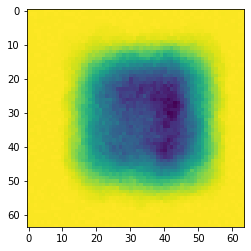

In [177]:
scm.condition({'N_scale': torch.tensor([1.0, 0.0, 0.0, 0.0, 0.0, 0.0]), 'N_shape':torch.tensor([0.0, 0.0, 1.0])}, n_steps = 500)

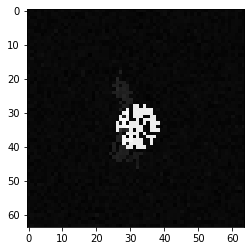

In [178]:
scm.counterfactual('N_shape', torch.tensor([0.0, 1.0, 0.0]), torch.tensor([1.0, 0., 0.]))